In [11]:
!pip install git+https://github.com/pablogiaccaglia/segmentation_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pablogiaccaglia/segmentation_pytorch to /tmp/pip-req-build-aizig2vc
  Running command git clone -q https://github.com/pablogiaccaglia/segmentation_pytorch /tmp/pip-req-build-aizig2vc
ERROR: File "setup.py" not found for legacy project git+https://github.com/pablogiaccaglia/segmentation_pytorch.


In [12]:
import os
import sys
import cv2
import time
import timeit
import random
import pathlib
import logging
import numpy as np
import albumentations
from tqdm import tqdm
from functools import partial
from typing import Tuple, List
import sys
!{sys.executable} -m pip install einops
!{sys.executable} -m pip install tensorflow_addons
!{sys.executable} -m pip install timm
!{sys.executable} -m pip install mmvc
!{sys.executable} -m pip install tensorboardX
!{sys.executable} -m pip install torchviz

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from mmcv.runner import build_optimizer

from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt
from torchviz import make_dot
from models.segformer import Segformer

%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)

from utils.label_utils import get_labels
from utils.lr_schedule import PolyLrUpdater
from utils.modelsummary import get_model_summary
from utils.runners import train, validate, testval
from utils.data_utils import label_mapping, SegmentationDataset, display, cityscapes_label_to_rgb
from utils.train_utils import AverageMeter, CrossEntropy, get_confusion_matrix, create_logger
from utils.transformations import (ComposeDouble, FunctionWrapperDouble, normalize, re_normalize,
                                   random_crop, random_resize, random_brightness, AlbuSeg2d, scale_aug)

from configs.segformer_config import config as cfg

labels = get_labels()
id2label =      { label.id      : label for label in labels }
trainid2label = { label.trainId : label for label in labels }

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement mmvc (from versions: none)
ERROR: No matching distribution found for mmvc
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


ModuleNotFoundError: ignored

In [ ]:
#@title **Data Loader**

def loadNumpyArrays(folderPath: str, arr, max, channels_first = False) -> np.ndarray:
    i = 0

    entries = os.listdir(folderPath)
    entries.sort()
    #print(entries)
    for entry in entries:

      if i==len(arr):
        break

      if ".DS_Store" not in str(entry) and "(1).npy" not in str(entry):

        l = np.load(folderPath + entry)
        #print(l.shape)
        
        if "IMG" in folderPath:
            l = np.dstack([l,l,l])
        else:
            # l = np.expand_dims(l, axis = -1)
            pass

        if "IMG" in folderPath:
          # l = tf.keras.applications.vgg16.preprocess_input(l)
          pass
        
        arr[i] = l
        i = i + 1
        if i==max:
          break
    return arr

def getDatasetArraysForNet() -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    trainingImgDir = "/content/drive/MyDrive/Arrays-cbis/Dataset-split-arrays/Training-Final-IMG-Arrayss/"
    trainingMaskDir = "/content/drive/MyDrive/Arrays-cbis/Dataset-split-arrays/Training-Final-MSK-Arrays/"
    validationImgDir = "/content/drive/MyDrive/Arrays-cbis/Dataset-split-arrays/Validation-Final-IMG-Arrays/"
    validationMaskDir = "/content/drive/MyDrive/Arrays-cbis/Dataset-split-arrays/Validation-Final-MSK-Arrays/"
    testingImgDir = "/content/drive/MyDrive/Arrays-cbis/Dataset-split-arrays/Testing-Final-IMG-Arrays/"
    testingMaskDir = "/content/drive/MyDrive/Arrays-cbis/Dataset-split-arrays/Testing-Final-MSK-Arrays/"

    h = w = 256
    batch1 = 20
    batch2  = 5
    channel_first = True

    if channel_first:
      dim1 = (batch1, 3, h, w)
      dim2 = (batch1, 1, h, w)
      dim3 = (batch2, 3, h, w)
      dim4 = (batch1, 1, h, w)
    else:
      dim1 = (batch1, h, w, 3)
      dim2 = (batch1, h, w, 1)
      dim3 = (batch2, h, w, 3)
      dim4 = (batch1, h, w, 1)


    return loadNumpyArrays(folderPath = trainingImgDir, arr = np.ndarray(dim1), dtype = 'float32'), max = 20, channel_first = channel_first), \
           loadNumpyArrays(folderPath = trainingMaskDir, arr = np.ndarray(dim2, dtype = 'uint8'), max = 20, channel_first = channel_first), \
           loadNumpyArrays(folderPath = validationImgDir, arr = np.ndarray(dim1, dtype = 'float32'), max = 20), \
           loadNumpyArrays( folderPath = validationMaskDir, arr = np.ndarray(dim2, dtype = 'uint8'), max = 20, channel_first = channel_first), \
           loadNumpyArrays(folderPath = testingImgDir, arr = np.ndarray(dim3, dtype = 'float32'), max = 20), loadNumpyArrays(folderPath = testingMaskDir, arr = np.ndarray(dim4, dtype = 'uint8'), max = 5, channel_first = channel_first)
                           

data = getDatasetArraysForNet()

In [ ]:
train_dataset = SegmentationDataset(cfg = cfg.DATASET, split = "train", transform = transforms_training)
valid_dataset = SegmentationDataset(cfg = cfg.DATASET, split = "val", transform = transforms_validation)

train_dataloader = DataLoader(
    dataset = train_dataset, 
    batch_size = cfg.TRAIN.ADJ_BATCH_SIZE, 
    shuffle = True,
    drop_last = True,
    num_workers = 4,
    prefetch_factor = 8,
    pin_memory=True
    
)
valid_dataloader = DataLoader(
    dataset = valid_dataset, 
    batch_size = cfg.TRAIN.ADJ_BATCH_SIZE, 
    shuffle = True,
    drop_last = True,
    num_workers = 4,
    prefetch_factor = 8,
    pin_memory=True
    
)

x, y, _, names = next(iter(train_dataloader))
xv, yv, _, vnames = next(iter(valid_dataloader))

x_min, x_max = x.min(), x.max()
print('x.shape: {}, x.type: {}, [min(x), max(x)]: [{:.3f}, {:.3f}]'.format(x.numpy().shape, x.dtype, x_min, x_max))
print('y.shape: {}, y.type: {} \ny unique: {}'.format(y.numpy().shape, y.dtype, np.unique(y.numpy()).tolist()))

Images: 2975 , Labels: 2975
Images: 500 , Labels: 500
x.shape: (2, 3, 1024, 1024), x.type: torch.float32, [min(x), max(x)]: [-2.118, 2.640]
y.shape: (2, 1024, 1024), y.type: torch.int64 
y unique: [0, 1, 2, 4, 5, 7, 8, 9, 10, 11, 12, 13, 17, 18, 255]


In [ ]:
def display_blend(display_list):
    plt.figure(figsize=(10, 10), dpi=200)
    for i in range(len(display_list)):
        blend = cv2.addWeighted(display_list[i][0], 0.8, display_list[i][1], 0.6, 0)
        plt.subplot(1, len(display_list), i+1)
        plt.imshow(blend)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

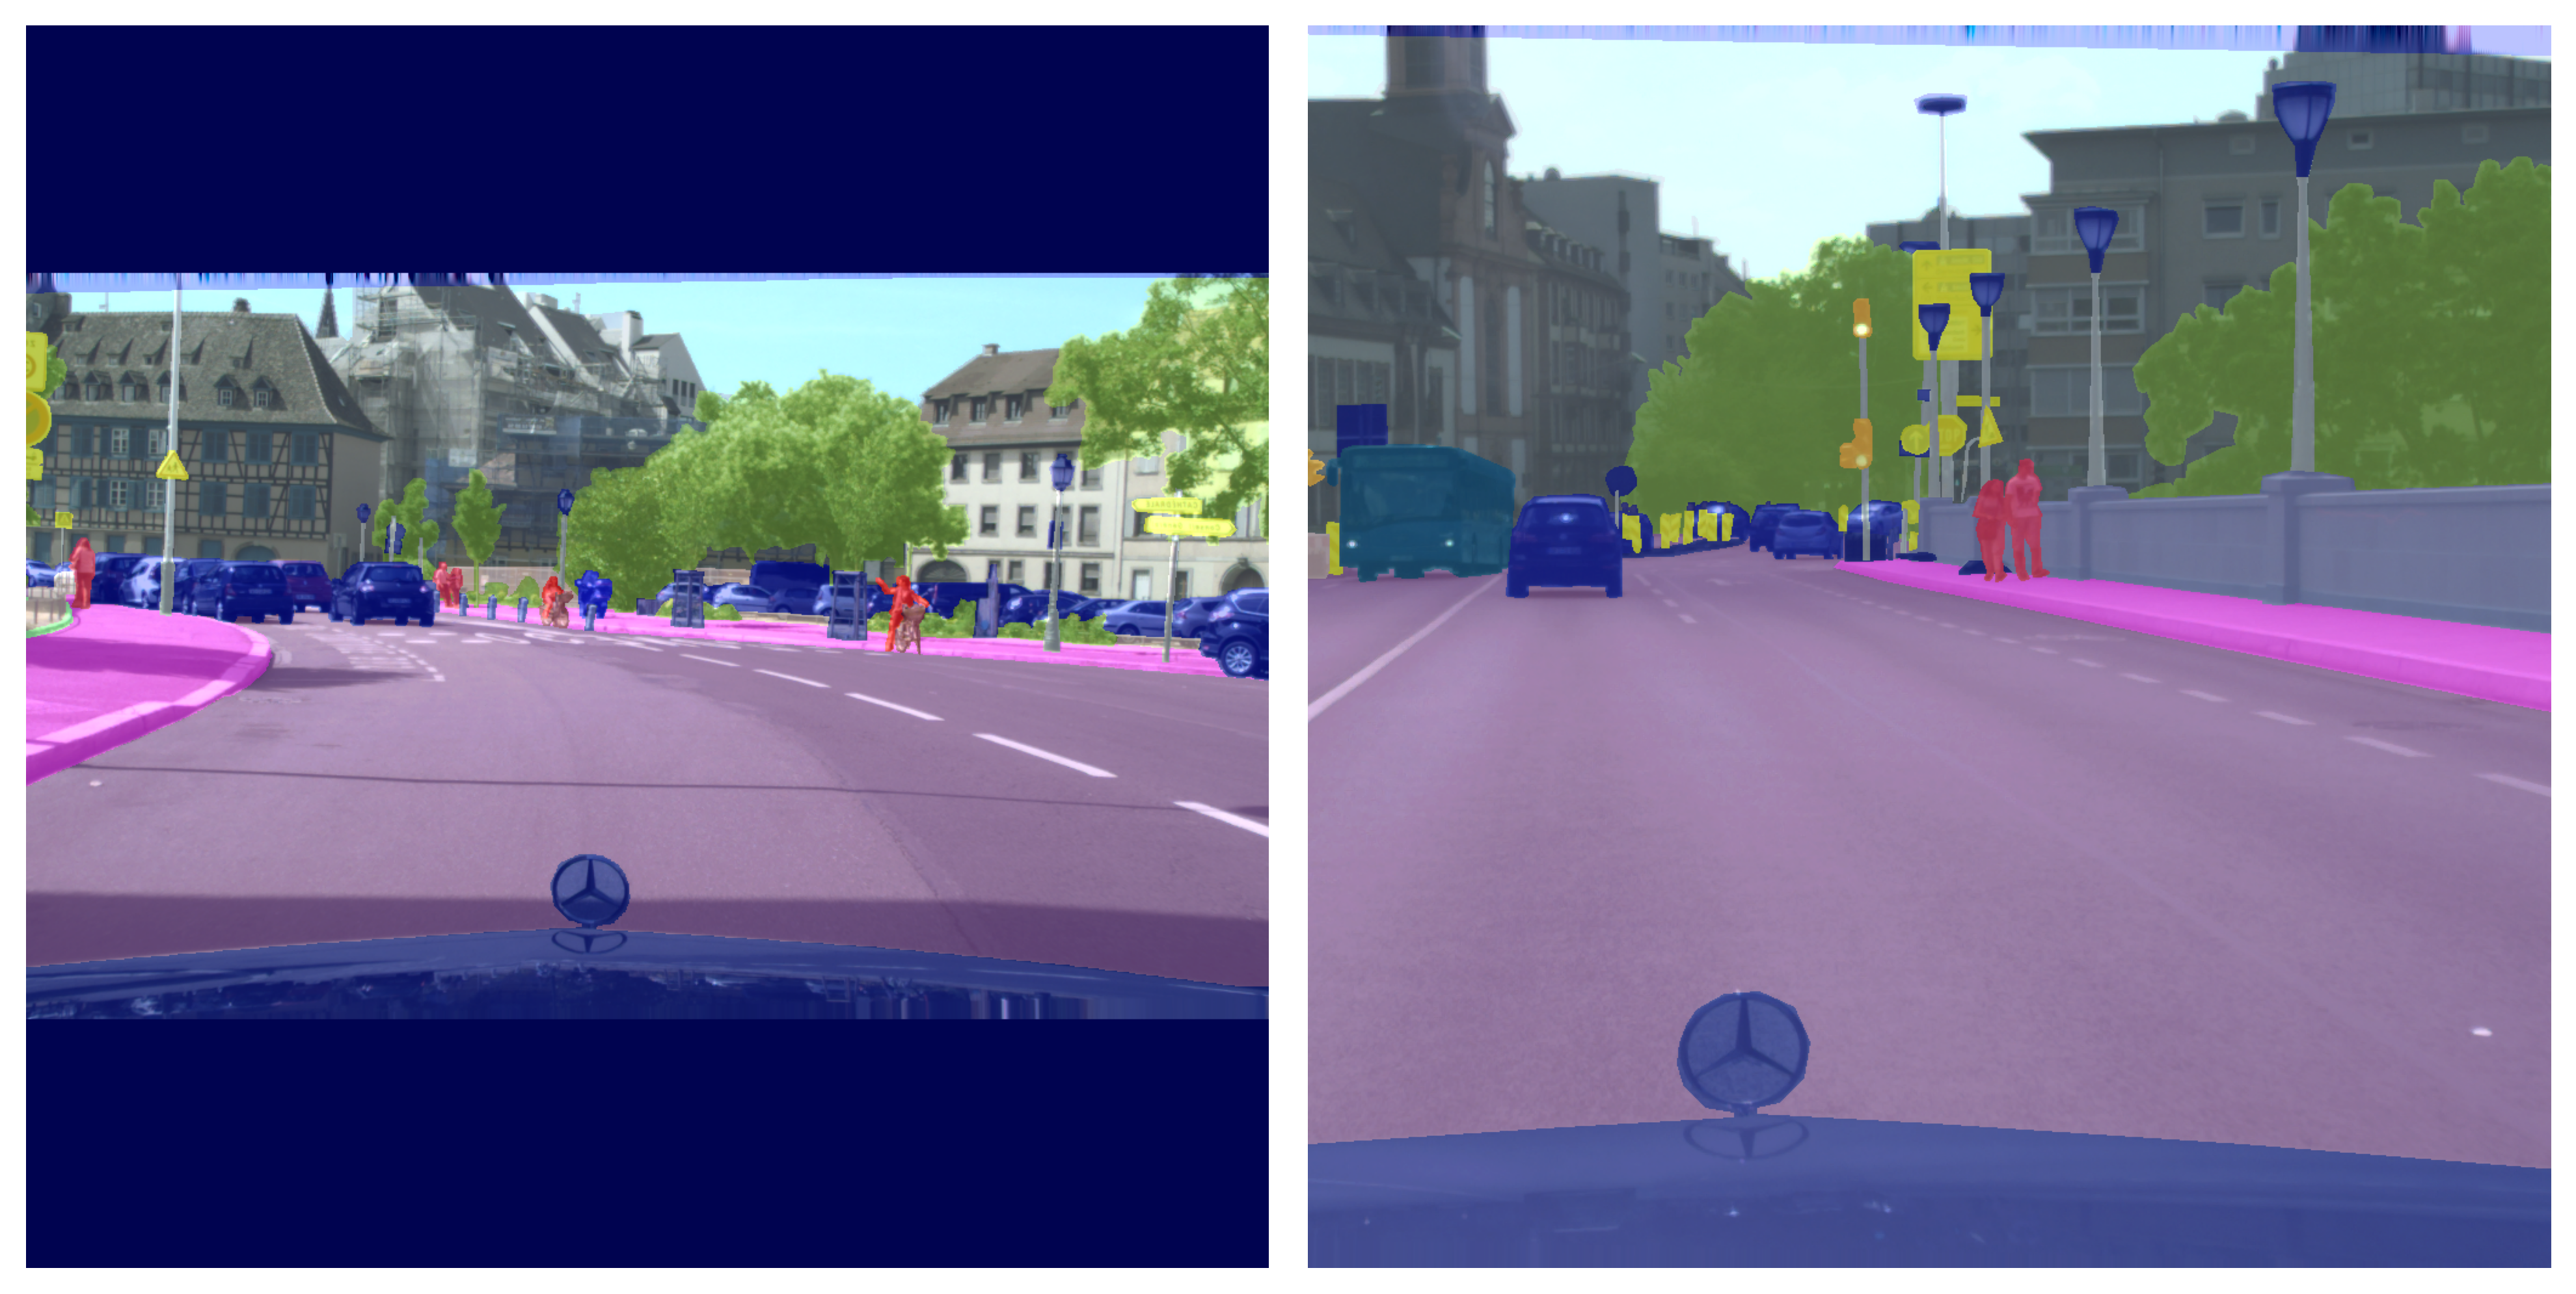

In [ ]:
idx = 1
display_blend([
    [re_normalize(x[idx].permute(1,2,0).numpy()), cityscapes_label_to_rgb(y[idx])],
    [re_normalize(xv[idx].permute(1,2,0).numpy()), cityscapes_label_to_rgb(yv[idx])]
])

In [ ]:
SEG_CFG = cfg.MODEL.B2

In [ ]:
model = Segformer(
    pretrained = SEG_CFG.PRETRAINED,
    img_size = cfg.DATASET.CROP_SIZE[0], 
    patch_size = cfg.MODEL.PATCH_SIZE, 
    embed_dims = SEG_CFG.CHANNEL_DIMS, 
    num_heads = SEG_CFG.NUM_HEADS, 
    mlp_ratios = SEG_CFG.MLP_RATIOS,
    qkv_bias = SEG_CFG.QKV_BIAS, 
    depths = SEG_CFG.DEPTHS, 
    sr_ratios = SEG_CFG.SR_RATIOS,
    drop_rate = SEG_CFG.DROP_RATE, 
    drop_path_rate = SEG_CFG.DROP_PATH_RATE,
    decoder_dim = SEG_CFG.DECODER_DIM,
    norm_layer = partial(nn.LayerNorm, eps=1e-6), 
).to(device)

2021-09-09 02:40:18,265 - mmseg - INFO - Use load_from_local loader
2021-09-09 02:40:18,324 - mmseg - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: head.weight, head.bias

missing keys in source state_dict: linear_c4.proj.weight, linear_c4.proj.bias, linear_c3.proj.weight, linear_c3.proj.bias, linear_c2.proj.weight, linear_c2.proj.bias, linear_c1.proj.weight, linear_c1.proj.bias, linear_fuse.weight, linear_fuse.bias, linear_pred.weight, linear_pred.bias



In [ ]:
criterion = CrossEntropy(
    ignore_label=cfg.DATASET.IGNORE_LABEL, 
    weight=train_dataset.class_weights
).to(device)


optimizer_cfg = dict(
    type=cfg.TRAIN.OPTIMIZER, 
    lr=cfg.TRAIN.BASE_LR,  
    weight_decay=cfg.TRAIN.WD,
    paramwise_cfg=dict(
        custom_keys={
            'pos_block': dict(decay_mult=0.), 
            'norm': dict(decay_mult=0.),
            'head': dict(lr_mult=10.)
        }
))

optimizer = build_optimizer(model, optimizer_cfg)

lr_scheduler = PolyLrUpdater(
    optimizer = optimizer,
    power = cfg.TRAIN.POWER,
    min_lr = cfg.TRAIN.MIN_LR,
    max_iters = cfg.TRAIN.DECAY_STEPS,
    epoch_len = len(train_dataloader),
    warmup = cfg.TRAIN.WARMUP,
    warmup_iters = cfg.TRAIN.WARMUP_ITERS,
    warmup_ratio = cfg.TRAIN.WARMUP_RATIO,
    by_epoch = cfg.TRAIN.BY_EPOCH,
)

In [ ]:
details = get_model_summary(model, x.cuda(), verbose=False)
print(details)


Total Parameters: 28,290,387
----------------------------------------------------------------------------------------------------
Total Multiply Adds (For Convolution and Linear Layers only): 19,709.265625 GFLOPs
----------------------------------------------------------------------------------------------------
Number of Layers
Conv2d : 35 layers   LayerNorm : 53 layers   OverlapPatchEmbed : 4 layers   Linear : 84 layers   Dropout : 64 layers   Attention : 16 layers   Identity : 2 layers   DWConv : 16 layers   GELU : 16 layers   Mlp : 16 layers   Block : 16 layers   DropPath : 30 layers   LinearMLP : 4 layers   Dropout2d : 1 layers   


In [ ]:
def train(
    cfg, 
    dataloader, 
    model, 
    loss_fn, 
    optimizer, 
    lr_scheduler, 
    scaler, 
    writer_dict,
    epoch, 
):
    model.train()
    
    ave_loss = AverageMeter()
    steps_tot = epoch*len(dataloader) 
    writer = writer_dict['writer']
    global_steps = writer_dict['train_global_steps']
    
    for step, batch in enumerate(dataloader):
        X, y, _, _ = batch
        X, y = X.cuda(), y.long().cuda() 
        
        # Compute prediction and loss
        with torch.cuda.amp.autocast():
            pred = model(X.contiguous())
            pred = F.interpolate(pred, size = cfg.DATASET.CROP_SIZE, mode = 'bilinear', align_corners = False)
            losses = loss_fn(pred, y)
        loss = losses.mean()
        
        # Normalize loss to account for batch accumulation
        loss = loss / cfg.TRAIN.ACCUM_STEPS
            
        # Backward pass
        scaler.scale(loss).backward()
        
        # Weight update
        if ((step + 1) % cfg.TRAIN.ACCUM_STEPS == 0) or (step + 1 == len(dataloader)):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

            # update average loss
            ave_loss.update(loss.item())

            # update learning schedule
            lr_scheduler.before_train_iter()
            lr = lr_scheduler.get_lr(int(steps_tot+step), cfg.TRAIN.BASE_LR)
        
        
    writer.add_scalar('train_loss', ave_loss.average(), global_steps)
    writer_dict['train_global_steps'] = global_steps + 1
    
    
def validate(
    cfg, 
    dataloader, 
    model, 
    loss_fn, 
    writer_dict
):
    model.eval()
    
    ave_loss = AverageMeter()
    iter_steps = len(dataloader.dataset) // cfg.TRAIN.BATCH_SIZE
    confusion_matrix = np.zeros((cfg.DATASET.NUM_CLASSES, cfg.DATASET.NUM_CLASSES, 1))
    
    with torch.no_grad():
        for idx, batch in enumerate(dataloader):
            X, y, _, _ = batch
            size = y.size()
            X, y = X.cuda(), y.long().cuda()
            
            pred = model(X.contiguous())
            pred = F.interpolate(pred, size = cfg.DATASET.CROP_SIZE, mode = 'bilinear', align_corners = False)
            losses = loss_fn(pred, y)
            loss = losses.mean()   
            
            if not isinstance(pred, (list, tuple)):
                pred = [pred]    
            for i, x in enumerate(pred):
                confusion_matrix[..., i] += get_confusion_matrix(
                    y, x, size, cfg.DATASET.NUM_CLASSES, cfg.DATASET.NUM_CLASSES)
            ave_loss.update(loss.item())
            
    pos = confusion_matrix[..., 0].sum(1)
    res = confusion_matrix[..., 0].sum(0)
    tp = np.diag(confusion_matrix[..., 0])
    IoU_array = (tp / np.maximum(1.0, pos + res - tp))
    mean_IoU = IoU_array.mean()
    
    writer = writer_dict['writer']
    global_steps = writer_dict['valid_global_steps']
    writer.add_scalar('valid_loss', ave_loss.average(), global_steps)
    writer.add_scalar('valid_mIoU', mean_IoU, global_steps)
    for key, val in trainid2label.items():
        if key != cfg.DATASET.IGNORE_LABEL and key != -1:
            if val.name == 'traffic light':
                val_name = "traffic_light"
            elif val.name == 'traffic sign':
                val_name = "traffic_sign"
            else:
                val_name = val.name
            writer.add_scalar('valid_mIoU_{}'.format(val_name), IoU_array[key], global_steps)    
    writer_dict['valid_global_steps'] = global_steps + 1
        
    return ave_loss.average(), mean_IoU, IoU_array

In [ ]:
def run_train_loop():
    
    logger, final_output_dir, tb_log_dir = create_logger(cfg, cfg_name=cfg.NAME, phase='train')
    
    writer_dict = {'writer': SummaryWriter(tb_log_dir), 'train_global_steps': 0, 'valid_global_steps': 0}

    best_mIoU = 0
    
    start = timeit.default_timer()
    for epoch in range(cfg.TRAIN.EPOCHS):
        
        e_start = time.time()

        train(
            cfg=cfg, 
            dataloader=train_dataloader, 
            model=model, 
            loss_fn=criterion, 
            optimizer=optimizer, 
            lr_scheduler=lr_scheduler,
            epoch=epoch, 
            scaler=torch.cuda.amp.GradScaler(),
            writer_dict=writer_dict
        )

        valid_loss, mean_IoU, IoU_array = validate(
            cfg=cfg, 
            dataloader=valid_dataloader, 
            model=model,  
            loss_fn=criterion,
            writer_dict=writer_dict
        )

        # logger.info('=> saving checkpoint to {}'.format(final_output_dir + 'checkpoint.pth.tar'))

        torch.save({
            'epoch': epoch+1,
            'best_mIoU': best_mIoU,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }, os.path.join(final_output_dir,'checkpoint.pth.tar'))

        if mean_IoU > best_mIoU:
            best_mIoU = mean_IoU
            torch.save(model.state_dict(), os.path.join(final_output_dir, 'best.pth'))
            
        e_end = time.time()
        t_epoch = e_end - e_start

        msg = 'Epoch {}/{} --- {:.1f}s, Loss: {:.3f}, MeanIoU: {: 4.4f}, Best_mIoU: {: 4.4f}'.format(
            epoch+1, cfg.TRAIN.EPOCHS, t_epoch, valid_loss, mean_IoU, best_mIoU)
        logging.info(msg)
        
    torch.save(model.state_dict(), os.path.join(final_output_dir, 'final_state.pth'))

    writer_dict['writer'].close()
    end = timeit.default_timer()
    logger.info('Hours: %d' % np.int((end-start)/3600))
    logger.info('Done')

In [ ]:
run_train_loop()

=> creating /workspace/PythonProjects/segmentation_pytorch/outputs/cityscapes/segformer_train_1024x1024_adamw_lr6e-6_wd1e-2_bs_8_epoch400
=> creating /workspace/PythonProjects/segmentation_pytorch/logs/cityscapes/segformer/segformer_train_1024x1024_adamw_lr6e-6_wd1e-2_bs_8_epoch400_2021-09-09-02-40


Epoch 1/400 --- 611.9s, Loss: 0.383, MeanIoU:  0.3914, Best_mIoU:  0.3914
Epoch 2/400 --- 608.2s, Loss: 0.282, MeanIoU:  0.4733, Best_mIoU:  0.4733
Epoch 3/400 --- 608.0s, Loss: 0.248, MeanIoU:  0.5333, Best_mIoU:  0.5333
Epoch 4/400 --- 608.0s, Loss: 0.207, MeanIoU:  0.5776, Best_mIoU:  0.5776
Epoch 5/400 --- 608.8s, Loss: 0.222, MeanIoU:  0.5634, Best_mIoU:  0.5776
Epoch 6/400 --- 608.7s, Loss: 0.187, MeanIoU:  0.6098, Best_mIoU:  0.6098
Epoch 7/400 --- 609.1s, Loss: 0.182, MeanIoU:  0.6453, Best_mIoU:  0.6453
Epoch 8/400 --- 608.7s, Loss: 0.201, MeanIoU:  0.6092, Best_mIoU:  0.6453
Epoch 9/400 --- 608.6s, Loss: 0.209, MeanIoU:  0.5771, Best_mIoU:  0.6453
Epoch 10/400 --- 609.0s, Loss: 0.183, MeanIoU:  0.6670, Best_mIoU:  0.6670
Epoch 11/400 --- 609.0s, Loss: 0.174, MeanIoU:  0.6781, Best_mIoU:  0.6781
Epoch 12/400 --- 608.8s, Loss: 0.176, MeanIoU:  0.6498, Best_mIoU:  0.6781
Epoch 13/400 --- 609.3s, Loss: 0.158, MeanIoU:  0.6912, Best_mIoU:  0.6912
Epoch 14/400 --- 608.9s, Loss: 0.1

KeyboardInterrupt: 

In [ ]:
mean_IoU, IoU_array, pixel_acc, mean_acc = testval(
    config, 
    eval_dataloader, 
    model, 
    sv_dir=cfg.OUTPUT_DIR, 
    sv_pred=True
)

In [ ]:
print("mnea IoU: {:.3f}, mean Accuracy: {:.3f}, Pixel Accuracy: {:.3f}".format(mean_IoU, mean_acc, pixel_acc))

In [ ]:
for key, val in trainid2label.items():
    if key != cfg.DATASET.IGNORE_LABEL and key != -1:
        print("{} --- IoU: {:.2f}".format(val.name, IoU_array[key]))